# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [88]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [89]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [90]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [91]:
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [92]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum().sum()


4896838

In [93]:
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [94]:
for idx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[idx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[idx]['attribute']: missing_or_unknown}, np.nan)

In [95]:
# for idx in range(len(feat_info)):
#     feat_info = feat_info.iloc[idx]['missing_or_unknown']
#     feat_info = feat_info.strip('[')
#     feat_info = feat_info.strip(']')
#     feat_info = feat_info.split(sep=',')
#     feat_info = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in feat_info]
#     if feat_info != ['']:
#         azdias = azdias.replace({feat_info.iloc[idx]['attribute']: feat_info}, np.nan)

In [96]:
azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [97]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = azdias.isnull().mean().sort_values(ascending = False) *100
missing_data

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

Text(0,0.5,'The number of columns')

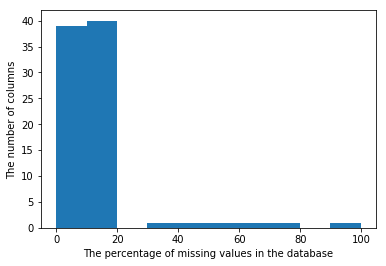

In [98]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data)
plt.xlabel('The percentage of missing values in the database')
plt.ylabel('The number of columns')


In [99]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
more_than_25 = missing_data[missing_data>25]
more_than_25

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [100]:
azdias.drop(more_than_25.index, axis=1, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Looking at the above plot threshold more than 20 and less than 30 (as a percentage of missing values in the datebase) seems to be the best, becuase we have a significant growth of the number of columns at 20. That is why I choose a treshold percentage here as 25 and therefore all the columns with more percantage of missing values could be removed.These columns are:
- TITEL_KZ - more than 99% of data missing - it does not make sense to leave those data, there is almost no info there for further analysis. This data seems to not be that relevant, because it shows us the person academic title. I do not see any error here - this is not an ordinary thing to be a doctor or profesor.
- AGER_TYP - ager typology, not very informative feature about life stage,
- KK_KUNDENTYP - customer pattern - also not very informatiive, like the feature about it is categorical value, rather based on personal experience, not numerical data, 
- KBA05_BAUMAX - most common building type within the microcell,
- GEBURTSJAHR - date of birth - this is interesting, becuase it seems to be relevant information and almost half of the data is missing here, maybe people did not want to share those very personal information. If almost half of the data is missing here, the data is not useful for further analysis.
- ALTER_HH - birthdate of head of household - similar pattern as in date of birth, but also the information is less relevant.

The patterns I noticed: 
- about 25 columns has no missing data - it mostly concerns financial and personality data - these might be very important data for further analysis,
- most of the columns have missing data in less than 20%, which for that big amount of database is understandable and acceptable,
- 6 columns identitifed above with more than 25% of missing data can be treated as outliers and therefore removed from the database.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

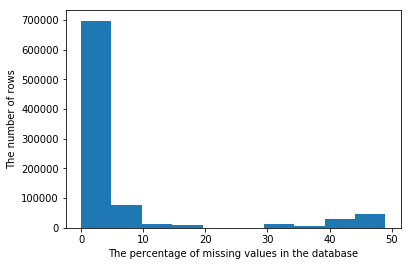

In [101]:
# How much data is missing in each row of the dataset?
missing_data_per_row = azdias.isnull().sum(axis=1)
plt.hist(missing_data_per_row)
plt.xlabel('The percentage of missing values in the database')
plt.ylabel('The number of rows')
plt.show()


In [102]:
missing_data_per_row.sort_values(ascending=False)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

In [103]:
missing_data_per_row.sum()

5035304

In [104]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
row_less_than_25 = azdias[azdias.isna().sum(axis=1)<25]
row_more_than_25 = azdias[azdias.isna().sum(axis=1)>=25]
azdias_less_than_25 = azdias.iloc[row_less_than_25.index,:]
azdias_more_than_25 = azdias.iloc[row_more_than_25.index,:]

In [105]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
np.random.seed(5468)
sample_columns = np.random.choice(azdias.columns, 5).tolist()
print(sample_columns)


['ZABEOTYP', 'SEMIO_KAEM', 'SEMIO_KULT', 'ORTSGR_KLS9', 'FINANZ_VORSORGER']


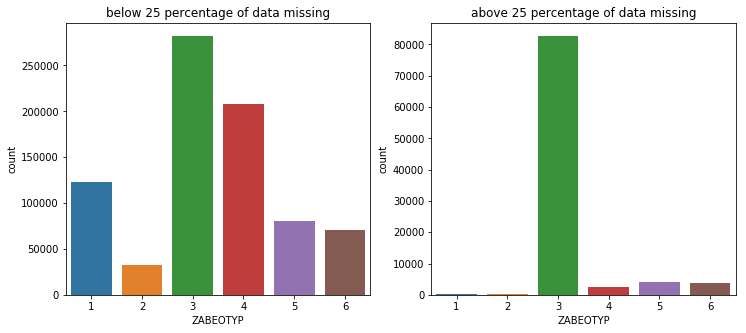

In [106]:
fig = plt.figure(8, figsize = (12,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('below 25 percentage of data missing')
sns.countplot(azdias_less_than_25['ZABEOTYP'])
ax2 = fig.add_subplot(122)
ax2.title.set_text('above 25 percentage of data missing')
sns.countplot(azdias_more_than_25['ZABEOTYP'])



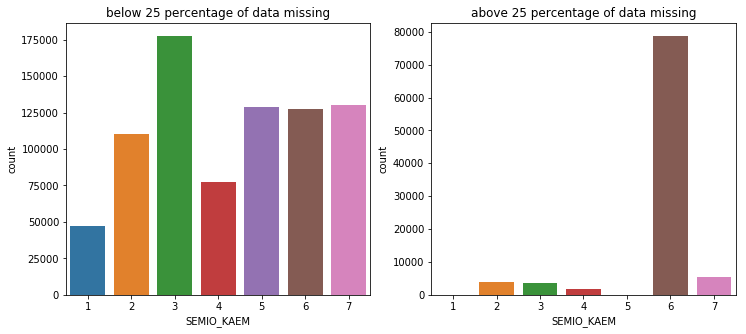

In [107]:
fig = plt.figure(8, figsize = (12,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('below 25 percentage of data missing')
sns.countplot(azdias_less_than_25['SEMIO_KAEM'])
ax2 = fig.add_subplot(122)
ax2.title.set_text('above 25 percentage of data missing')
sns.countplot(azdias_more_than_25['SEMIO_KAEM'])


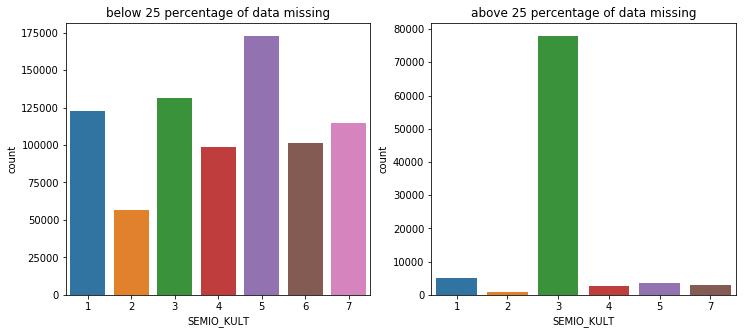

In [108]:
fig = plt.figure(8, figsize = (12,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('below 25 percentage of data missing')
sns.countplot(azdias_less_than_25['SEMIO_KULT'])
ax2 = fig.add_subplot(122)
ax2.title.set_text('above 25 percentage of data missing')
sns.countplot(azdias_more_than_25['SEMIO_KULT'])


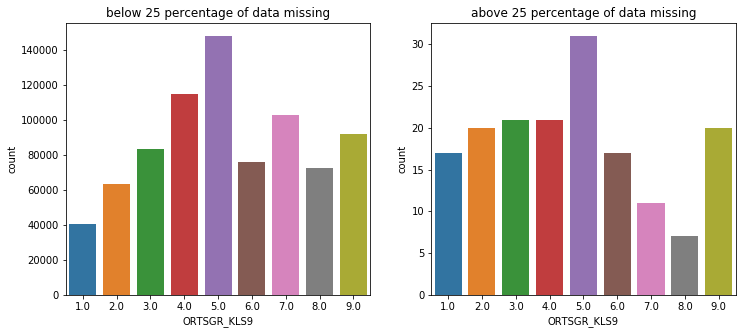

In [109]:
fig = plt.figure(8, figsize = (12,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('below 25 percentage of data missing')
sns.countplot(azdias_less_than_25['ORTSGR_KLS9'])
ax2 = fig.add_subplot(122)
ax2.title.set_text('above 25 percentage of data missing')
sns.countplot(azdias_more_than_25['ORTSGR_KLS9'])


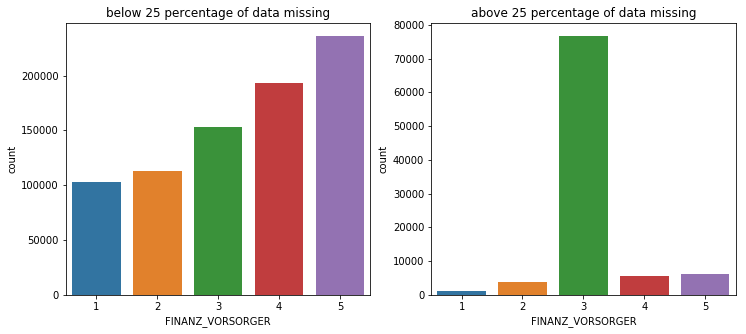

In [110]:
fig = plt.figure(8, figsize = (12,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('below 25 percentage of data missing')
sns.countplot(azdias_less_than_25['FINANZ_VORSORGER'])
ax2 = fig.add_subplot(122)
ax2.title.set_text('above 25 percentage of data missing')
sns.countplot(azdias_more_than_25['FINANZ_VORSORGER'])


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Yes, data with lots of missing values are equalitatively different frmo data with few or no missing values.
Y axis shows the count of each unique values in the subset of data and it is distributed differently for group when below 25% of data is missing and for the group when above 25% of data is missing for each chosen feature.
As instructed, if the data distributions in the two subsets are similar, then the one with a lot of missing vaules can be dropped for futher analysis. This is not the case here and also this is not a standard situation. Removing the data can lead to decreasing the number of significant information and the clustering in next steps might not be reliable. However, as instructed, from now on, I will be working on the data using just the subset with below of 25% of values missing.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [111]:
# more_than_25_columns = ['KBA05_BAUMAX','KK_KUNDENTYP','ALTER_HH','TITEL_KZ','GEBURTSJAHR','AGER_TYP']
# feat_info = feat_info.set_index('attribute').drop(more_than_25_columns).reset_index()
new_list = azdias.columns.tolist()
feat_info_1 = feat_info[feat_info['attribute'].isin(new_list)]
                        

In [112]:
# Removing the 6 outlier columns that were removed from feat_info
feat_info_1['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [113]:
feat_info_1.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [114]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info_1[feat_info.type == 'categorical'].attribute
print(categorical_features)
# categorical_features = list(azdias_less_than_25.select_dtypes("object").columns)
# print(categorical_features)

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [115]:
# Re-encode categorical variable(s) to be kept in the analysis.
binary = []
multi_level = []
for feature in categorical_features:
    if azdias_less_than_25[feature].nunique() > 2:
        multi_level.append(feature)
    else:
        binary.append(feature)

In [116]:
print(binary)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [117]:
azdias_less_than_25['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
# azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
# replace({'W':0, 'O':1}

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [118]:
print(multi_level)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [119]:
azdias_less_than_25 = azdias_less_than_25.drop(multi_level, axis = 1)

In [120]:
azdias_less_than_25.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Binary features - all numerical has been left as they are (according to instructions). OST_WEST_KZ has values -1, O or W, therefore O and W has been replace to 0 and 1 - the values needed to be re-encoded as numbers or dummy variable has to be created. All of binary features (5 only) has been left for futher analysis.
Multi level features, as they were 11, were decided to be dropped. Those could be re-encoded as well 9with multiple dummy variables), but for simplicity of calculation, they were removed.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [121]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade = {np.nan:np.nan, 1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

#mainstream = 1, avantgarde = 0
movement = {np.nan:np.nan, 1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

azdias_less_than_25['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_less_than_25['PRAEGENDE_JUGENDJAHRE'].map(decade)
azdias_less_than_25['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_less_than_25['PRAEGENDE_JUGENDJAHRE'].map(movement)

In [122]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#wealthy = 1, prosperous = 2, comfortable = 3, less affluent = 4, poorer = 5
wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

#pre-family = 1, young couples w/children = 2, families w.school age children = 3, older families = 4, eldres = 5 
life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_less_than_25['CAMEO_INTL_2015_WEALTH'] = azdias_less_than_25['CAMEO_INTL_2015'].map(wealth)
azdias_less_than_25['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_less_than_25['CAMEO_INTL_2015'].map(life_stage)

In [123]:
azdias_less_than_25 = azdias_less_than_25.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1)

In [124]:
azdias_less_than_25.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,90.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,70.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,70.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I kept these two mixed-value features:

PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 are two-mixed-value features which has been recombines to be useful in further analysis. 
For PRAEGENDE_JUGENDJAHRE there were 2 new feature variable created - one represented to decade, one to movement. The later has 2 binary variables - 1 for mainstream and 0 for avantgarde. For decade there was years used to differentiate. Based on that there was 2 dictionaries created, so the new feature values has been matched (mapped) with the initial ones.
For CAMEO_INTL_2015 it was similar, but because of two-digit code, it has to be broken into 2 dictionaries - 1st for the level of wealth, 2nd for the life stage.
After all the new variables has been mapped, they replaces the initial feature values. With the new created values, the initial mixed-value features could be dropped off from further analysis. From now on, the new features will be in use.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [125]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [126]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [128]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
#     for column in range(df.shape[1]):
#         feat_list = feat_info.iloc[column,3]
#         feat_list = feat_info.split(sep=',')
#         feat_list = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in feat_list]
#         if feat_list != ['']:
#             df = df.replace({feat_info.iloc[column]['attribute']: feat_list}, np.nan)   
    for index in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[index]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[index]['attribute']: missing_or_unknown}, np.nan)   

    # remove selected columns and rows, ...
    df.multi_level = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    df.drop(df.multi_level, axis=1)
    df.outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(df.outlier_columns, axis=1)
    df = df[df.isna().sum(axis=1)<25]
    df = df.loc[df.index,:]


    df = df[df['CAMEO_INTL_2015'] != 'XX']
    df.drop(['CAMEO_DEU_2015'], axis=1, inplace = True)

    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':0, 'O':1})
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x : 0 if x == 'W' else 1)
    


    decade = {np.nan:np.nan, 1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

#     mainstream = 1, avantgarde = 0
    movement = {np.nan:np.nan, 1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade)  
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)

#     df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    
#     wealthy = 1, prosperous = 2, comfortable = 3, less affluent = 4, poorer = 5
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

#     pre-family = 1, young couples w/children = 2, families w.school age children = 3, older families = 4, eldres = 5 
    life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].map(wealth)

    
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].map(life_stage)
    df = df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1)
    
    # Return the cleaned dataframe.
    return df







In [129]:
#  Perform feature trimming, re-encoding, and engineering for demographics
#     data
    
#     INPUT: Demographics DataFrame
#     OUTPUT: Trimmed and cleaned demographics DataFrame
#     """
    
#     # Put in code here to execute all main cleaning steps:
#     # convert missing value codes into NaNs, ...
    
    
#     for index in range(len(feat_info)):
#         missing_or_unknown = feat_info.iloc[index]['missing_or_unknown']
#         missing_or_unknown = missing_or_unknown.strip('[')
#         missing_or_unknown = missing_or_unknown.strip(']')
#         missing_or_unknown = missing_or_unknown.split(sep=',')
#         missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
#         if missing_or_unknown != ['']:
#             df = df.replace({feat_info.iloc[index]['attribute']: missing_or_unknown}, np.nan)   

#     # remove selected columns and rows, ...
    
#     df.outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
#     df = df.drop(df.outlier_columns, axis=1)
    
#     missing_data = df.isnull().mean().sort_values(ascending = False) *100
    
#     more_than_25 = missing_data[missing_data>25]
#     df.drop(more_than_25.index, axis=1, inplace=True)

#     missing_data_per_row = df.isnull().sum(axis=1)

    
#     row_less_than_25 = df[df.isna().sum(axis=1)<25]

    
#     row_more_than_25 = df[df.isna().sum(axis=1)>=25]

#     df_less_than_25 = df.iloc[row_less_than_25.index,:]

    
#     df_more_than_25 = df.iloc[row_more_than_25.index,:]

    
# #     more_than_25_columns = ['KBA05_BAUMAX','KK_KUNDENTYP','ALTER_HH','TITEL_KZ','GEBURTSJAHR','AGER_TYP']
    
    
# #     new_list = df_less_than_25.columns.tolist()
# #     feat_info_1 = df.feat_info[df.feat_info['attribute'].isin(new_list)]
    
#     new_list = df_less_than_25.columns.tolist()
#     feat_info_1 = feat_info[feat_info['attribute'].isin(new_list)]
# #     categorical_features = list(df_less_than_25.select_dtypes("object").columns)
# #     print(categorical_features)
    
#     categorical_features = feat_info_1[feat_info.type == 'categorical'].attribute
#     print(categorical_features)

#     # select, re-encode, and engineer column values.
#     binary = []
#     multi_level = []
#     for feature in categorical_features:
#         if df_less_than_25[feature].nunique() > 2:
#             multi_level.append(feature)
#         else:
#             binary.append(feature)

#     df_less_than_25['OST_WEST_KZ'] = df_less_['OST_WEST_KZ'].astype(str)
#     df_less_than_25['OST_WEST_KZ'].convert_dtypes()
#     df_less_than_25['OST_WEST_KZ'] = df_less_than_25['OST_WEST_KZ'].to_string()
#     df_less_than_25['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)

    
#     df_less_than_25 = df_less_than_25.drop(multi_level, axis = 1)
# #     df.outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
# #     df_less_than_25 = df_less_than_25.drop(df.outlier_columns, axis=1)
# #     print(df_less_than_25)
    
#     decade = {np.nan:np.nan, 1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

# #     mainstream = 1, avantgarde = 0
#     movement = {np.nan:np.nan, 1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

#     df_less_than_25['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_less_than_25['PRAEGENDE_JUGENDJAHRE'].map(decade)

    
#     df_less_than_25['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_less_than_25['PRAEGENDE_JUGENDJAHRE'].map(movement)

# #     wealthy = 1, prosperous = 2, comfortable = 3, less affluent = 4, poorer = 5
#     wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

# #     pre-family = 1, young couples w/children = 2, families w.school age children = 3, older families = 4, eldres = 5 
#     life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

#     df_less_than_25['CAMEO_INTL_2015_WEALTH'] = df_less_than_25['CAMEO_INTL_2015'].map(wealth)

    
#     df_less_than_25['CAMEO_INTL_2015_LIFE_STAGE'] = df_less_than_25['CAMEO_INTL_2015'].map(life_stage)

    
#     df_less_than_25 = df_less_than_25.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1)

    
#     # Return the cleaned dataframe.
#     return df_less_than_25


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [130]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
filler = Imputer(strategy="most_frequent")
values = filler.fit_transform(azdias_less_than_25)
azdias_less_than_25 = pd.DataFrame(values, columns = azdias_less_than_25.columns)

In [131]:
azdias_less_than_25.isnull().sum().sum()

0

In [171]:
azdias.isnull().sum().sum()

5035304

In [169]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled = scaler.fit_transform(azdias_less_than_25)
scaled = pd.DataFrame(scaled, columns = azdias_less_than_25.columns)

In [133]:
scaled.shape[1]

68

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
The simpliest way here to deal with missing values was impute the data with Imputer with the most frequent strategy - means missing values were replaced by the most frequent value along each column. Using median here, would be also good idea. Missing values has to be removed, because of sklearn requirements. After that, once, the data are "clean", feature scaling to the general population demographics data was applied. I used here StandardScaler, which scale each feature to standard deviation 1 and mean 0. Now the data are properly prepared to apply principal component analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [134]:
# Apply PCA to the data.
n_components = scaled.shape[1] // 2
pca = PCA(n_components = n_components)
X_pca = pca.fit(scaled)
X_pca

PCA(copy=True, iterated_power='auto', n_components=34, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

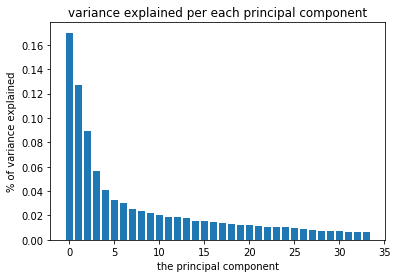

In [135]:
# Investigate the variance accounted for by each principal component.
plt.bar(np.arange(n_components), X_pca.explained_variance_ratio_)
plt.title("variance explained per each principal component")
plt.xlabel("the principal component")
plt.ylabel("% of variance explained")
plt.show()

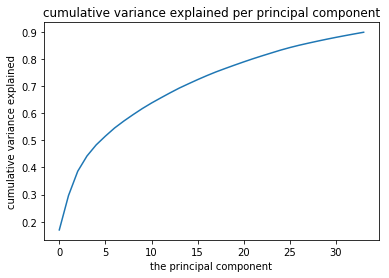

In [136]:
plt.plot(np.arange(n_components), np.cumsum(X_pca.explained_variance_ratio_))
plt.title("cumulative variance explained per principal component")
plt.xlabel("the principal component")
plt.ylabel("cumulative variance explained")
plt.show()

In [137]:
print("X_pca.explained_variance_ratio_", X_pca.explained_variance_ratio_.sum())
print("n_components", pca.n_components)

X_pca.explained_variance_ratio_ 0.898010306424
n_components 34


In [138]:
n_components = [30,36,40,45]
for n in n_components:
    pca = PCA(n)
    X_pca = pca.fit(scaled)
    print(pca.explained_variance_ratio_.sum())
    print(pca.n_components)        

0.872236673995
30
0.909627163674
36
0.929123419114
40
0.949171505478
45


In [139]:
# Re-apply PCA to the data while selecting for number of components to retain.
X_pca = X_pca.fit(scaled)
pca_data = X_pca.transform(scaled)



### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
At first I choose to reduce the number of components by 2 (so 34, because we havd 68 initial components. Looking at the cumulative variance explained per principal components, I it is on level about 89,8% for 34 components. It means almost 90% of the information is still retained, while the components have been reduced by half. I found it as a really good results and decided to select 34 as a number of components to retain.
I have checked also a few bigger/smaller number to have an overview if a good decision was made. I think the differences are not big and it does not make sense to use more components in this case. Just about 20% of the data is lost, while the half of components is cut off.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [140]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(df, x):
    weights = pd.DataFrame(pca.components_, columns = list(df.columns)).iloc[x]
    weights.sort_values(ascending=False, inplace=True)
    return weights


In [141]:
print(pca_weights(scaled, 0))

PLZ8_ANTG3                        0.224006
PLZ8_ANTG4                        0.217134
PLZ8_BAUMAX                       0.213999
CAMEO_INTL_2015_WEALTH            0.199643
ORTSGR_KLS9                       0.197308
HH_EINKOMMEN_SCORE                0.196602
EWDICHTE                          0.194738
FINANZ_HAUSBAUER                  0.162899
PLZ8_ANTG2                        0.152458
KBA05_ANTG4                       0.152358
ARBEIT                            0.141082
ANZ_HAUSHALTE_AKTIV               0.134548
RELAT_AB                          0.133463
KBA05_ANTG3                       0.133058
FINANZ_SPARER                     0.121382
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.103983
SEMIO_PFLICHT                     0.091676
SEMIO_REL                         0.088866
PRAEGENDE_JUGENDJAHRE_DECADE      0.081658
SEMIO_RAT                         0.075021
SEMIO_TRADV                       0.065669
SEMIO_MAT                         0.063306
SEMIO_FAM                         0.062497
W_KEIT_KIND

In [142]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pca_weights(scaled, 1))


ALTERSKATEGORIE_GROB            0.269894
FINANZ_VORSORGER                0.242490
SEMIO_ERL                       0.235374
SEMIO_LUST                      0.188489
RETOURTYP_BK_S                  0.163537
SEMIO_KRIT                      0.113812
W_KEIT_KIND_HH                  0.112324
SEMIO_KAEM                      0.106612
FINANZ_HAUSBAUER                0.098447
FINANZ_MINIMALIST               0.089572
ANREDE_KZ                       0.087385
EWDICHTE                        0.073074
ORTSGR_KLS9                     0.071945
PLZ8_ANTG3                      0.068668
SEMIO_DOM                       0.068350
PLZ8_ANTG4                      0.067993
WOHNDAUER_2008                  0.064848
PLZ8_BAUMAX                     0.063066
KBA05_ANTG4                     0.053568
ARBEIT                          0.052599
RELAT_AB                        0.051089
CAMEO_INTL_2015_WEALTH          0.050143
PLZ8_ANTG2                      0.047895
ANZ_HAUSHALTE_AKTIV             0.047273
HH_EINKOMMEN_SCO

In [143]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pca_weights(scaled, 2))


SEMIO_VERT                        0.346100
SEMIO_SOZ                         0.262279
SEMIO_FAM                         0.249083
SEMIO_KULT                        0.235043
FINANZ_MINIMALIST                 0.159894
RETOURTYP_BK_S                    0.105988
FINANZ_VORSORGER                  0.099971
W_KEIT_KIND_HH                    0.079201
ALTERSKATEGORIE_GROB              0.077611
SEMIO_REL                         0.068807
SEMIO_LUST                        0.063079
SEMIO_MAT                         0.056184
GREEN_AVANTGARDE                  0.054871
ORTSGR_KLS9                       0.047470
PLZ8_BAUMAX                       0.047190
EWDICHTE                          0.046315
PLZ8_ANTG4                        0.044904
PLZ8_ANTG3                        0.043285
WOHNDAUER_2008                    0.033752
ARBEIT                            0.033674
RELAT_AB                          0.030989
PLZ8_ANTG2                        0.028901
KBA05_ANTG4                       0.024709
CAMEO_INTL_

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

First principal component:
5 top positive values:
PLZ8_ANTG3                        0.224006 (Number of 6-10 family houses in the PLZ8 region)
PLZ8_ANTG4                        0.217134 (Number of 10+ family houses in the PLZ8 region)
PLZ8_BAUMAX                       0.213999 (Most common building type within the PLZ8 region)
CAMEO_INTL_2015_WEALTH            0.199643 (German CAMEO: Wealth / Life Stage Typology, mapped to international code)
ORTSGR_KLS9                       0.197308 (Size of community)

5 top negative values:
FINANZ_MINIMALIST                -0.204036 (Financial typology - low financial interest)
KBA05_ANTG1                      -0.208395 (Number of 1-2 family houses in the microcell)
KBA05_GBZ                        -0.211606 (Number of buildings in the microcell)
MOBI_REGIO                       -0.219257 (Movement patterns)
PLZ8_ANTG1                       -0.224244 (Number of 1-2 family houses in the PLZ8 region)

First principal components is related to the type/standard of living of the families (number of 6-+10 family houses, most common buildings in the region, size of community). The share of 10+ family homes (PLZ8_ANTG3) and the share of 6-10 family houses (PLZ8_ANTG4) seems to increase together and dicrease together with number of 1-2 family houses (PLZ8_ANTG1)
The possitive values are weighted towards wealth and life stage of people, which is also correlated to standard of living.
The first component negatively correlates against low financial interest (minimalist) and movement patterns and it is concerned for big family homes and their level of wealth.

Second principal component:
5 top positive values:
ALTERSKATEGORIE_GROB            0.269894 (Estimated age based on given name analysis)
FINANZ_VORSORGER                0.242490 (Financial typology - be prepared)
SEMIO_ERL                       0.235374 (Personality typology - event-oriented)
SEMIO_LUST                      0.188489 (Personality typology - sensual-minded)
RETOURTYP_BK_S                  0.163537 (Return type)

5 top negative values:
SEMIO_TRADV                    -0.237962 (Personal typology - tradional-minded)
SEMIO_PFLICHT                  -0.239041 (Personal typology - dutiful)
FINANZ_SPARER                  -0.249622 (Financial typology - money-saver)
PRAEGENDE_JUGENDJAHRE_DECADE   -0.251039 (Dominating movement of person's youth)
SEMIO_REL                      -0.265042 (Personal typology - religious)

The second component is about financial and personal typology mostly - possitively correlated with personalities which are event and sensual oriented and those people are also financialy prepared for living and future. Against it we have religious people, who are traditional and saves money. It seems to me that the possitive correlation can concern here younger people with different point of view for living, finances and the negative correlation can concern older people, other generation, which is duitful and traditional


Third principal component:
5 top positive values:
SEMIO_VERT                        0.346100 (Personal typoloy - dreamful)
SEMIO_SOZ                         0.262279 (Personal typology - socially-minded)
SEMIO_FAM                         0.249083 (Personal typology - family-minded)
SEMIO_KULT                        0.235043 (Personal typology - cultural-minded)
FINANZ_MINIMALIST                 0.159894 (Financial typology - low financial interest)

5 top negative values:
SEMIO_RAT                        -0.216219 (Personal typoloy - rational)
SEMIO_KRIT                       -0.276906 (Personal typoloy - critical-minded)
SEMIO_DOM                        -0.312523 (Personal typoloy - dominant-minded)
SEMIO_KAEM                       -0.336291 (Personal typoloy - combative attitude)
ANREDE_KZ                        -0.367910 (Gender)
 
The third component is about personal typology - negatively associated towards personalities which are dominant, rational, traditional, combat. Might be it is the type of people who are in elder age and have some experiences with war/military in the past, but that might be an overinterpretation. The possitive values are weighted towards people who are joyful, open-minded, focused on families, culture and social file and at the same time have low financial interest. The component seems personality-driven.


These top features reflects the overall principal component.




## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [144]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    kmeans.fit(data)
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(data))
    return score

In [145]:
scores = []
centers = list(range(2,21,2))

for center in centers:
    scores.append(get_kmeans_score(pca_data, center))

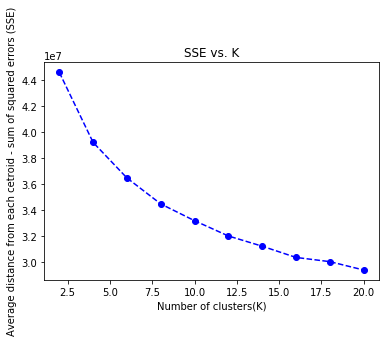

In [146]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of clusters(K)');
plt.ylabel('Average distance from each cetroid - sum of squared errors (SSE)');
plt.title('SSE vs. K');


In [147]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=16)
kmeans = kmeans.fit(pca_data)
prediction_general_population = kmeans.predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)
The scores plotted are the sum of the squared distances from each point to its corresponding centroid - sum of squared errors. The plot created not clearly indicates where the elbow is. The elbow helps to determinate how many PCAs we need to capture the majority of the variation of the data. In this case it will be most likely 16. So, the general population will be segmented by 16 number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [148]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
percent_missing = customers.isnull().sum() * 100 / len(customers)
missing_value_df = pd.DataFrame({'column_name': customers.columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)


                                 column_name  percent_missing
AGER_TYP                            AGER_TYP         0.000000
ALTERSKATEGORIE_GROB    ALTERSKATEGORIE_GROB         0.000000
ANREDE_KZ                          ANREDE_KZ         0.000000
CJT_GESAMTTYP                  CJT_GESAMTTYP         1.676476
FINANZ_MINIMALIST          FINANZ_MINIMALIST         0.000000
FINANZ_SPARER                  FINANZ_SPARER         0.000000
FINANZ_VORSORGER            FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER                FINANZ_ANLEGER         0.000000
FINANZ_UNAUFFAELLIGER  FINANZ_UNAUFFAELLIGER         0.000000
FINANZ_HAUSBAUER            FINANZ_HAUSBAUER         0.000000
FINANZTYP                          FINANZTYP         0.000000
GEBURTSJAHR                      GEBURTSJAHR         0.000000
GFK_URLAUBERTYP              GFK_URLAUBERTYP         1.676476
GREEN_AVANTGARDE            GREEN_AVANTGARDE         0.000000
HEALTH_TYP                        HEALTH_TYP         0.000000
LP_LEBEN

In [181]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleaned = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [182]:
cleaned.isnull().sum().sum()

162507

In [183]:
cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,4.0,1,5.0,5,1,5,1,2,2,2,...,1.0,5.0,5.0,1.0,2.0,1.0,50.0,0.0,1.0,3.0
2,4.0,2,2.0,5,1,5,1,4,4,2,...,3.0,3.0,2.0,3.0,5.0,3.0,50.0,0.0,3.0,4.0
3,4.0,1,2.0,5,1,5,2,1,2,6,...,1.0,3.0,4.0,1.0,3.0,1.0,40.0,1.0,2.0,4.0
4,3.0,1,6.0,3,1,4,4,5,2,2,...,2.0,3.0,3.0,3.0,5.0,1.0,70.0,1.0,4.0,1.0
5,3.0,1,4.0,5,1,5,1,2,3,5,...,1.0,5.0,5.0,3.0,7.0,5.0,50.0,0.0,3.0,4.0


In [184]:
customers_clean = cleaned.dropna()

In [185]:
customers_clean.isnull().sum().sum()

0

In [186]:
cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,4.0,1,5.0,5,1,5,1,2,2,2,...,1.0,5.0,5.0,1.0,2.0,1.0,50.0,0.0,1.0,3.0
2,4.0,2,2.0,5,1,5,1,4,4,2,...,3.0,3.0,2.0,3.0,5.0,3.0,50.0,0.0,3.0,4.0
3,4.0,1,2.0,5,1,5,2,1,2,6,...,1.0,3.0,4.0,1.0,3.0,1.0,40.0,1.0,2.0,4.0
4,3.0,1,6.0,3,1,4,4,5,2,2,...,2.0,3.0,3.0,3.0,5.0,1.0,70.0,1.0,4.0,1.0
5,3.0,1,4.0,5,1,5,1,2,3,5,...,1.0,5.0,5.0,3.0,7.0,5.0,50.0,0.0,3.0,4.0


In [187]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,4.0,1,5.0,5,1,5,1,2,2,2,...,1.0,5.0,5.0,1.0,2.0,1.0,50.0,0.0,1.0,3.0
2,4.0,2,2.0,5,1,5,1,4,4,2,...,3.0,3.0,2.0,3.0,5.0,3.0,50.0,0.0,3.0,4.0
4,3.0,1,6.0,3,1,4,4,5,2,2,...,2.0,3.0,3.0,3.0,5.0,1.0,70.0,1.0,4.0,1.0
5,3.0,1,4.0,5,1,5,1,2,3,5,...,1.0,5.0,5.0,3.0,7.0,5.0,50.0,0.0,3.0,4.0
6,4.0,1,2.0,5,1,5,1,1,2,2,...,1.0,5.0,5.0,2.0,3.0,2.0,50.0,0.0,2.0,3.0


In [188]:
#scalling, PCA transformation, kmeans prediction

scaled_cust = scaler.transform(customers_clean)


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [180]:
scaled_cust = pd.DataFrame(scaled_cust, columns=customers_clean.columns)

pca_customers = X_pca.transform(scaled_cust)

predict_customers = kmeans.predict(pca_customers)

NameError: name 'scaled_cust' is not defined

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.